In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
from alplakes import parse_alplakes_1d_from_directory

### Parameters

In [3]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'

model = 'geneva_200m_secchi-half'

In [4]:
var_to_plot = 'THETA'

## Import cropped netcdf MITgcm results

In [5]:
xr_dalton = xr.open_dataset(r"D:\geneva_200m_dalton\cropped_results_nc\lexplore_depth_time_cdalton063.nc")

In [6]:
xr_secchi = xr.open_dataset(r"D:\geneva_200m_secchi_half\cropped_results_nc\lexplore_depth_time.nc")

In [7]:
xr_mitgcm = xr.open_dataset(r"D:\new_geneva_200m\cropped_results_nc\lexplore_temp_depth_time.nc")

In [8]:
start_date = pd.to_datetime(xr_dalton['time'].values[0]).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(xr_dalton['time'].values[-1]).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)

## Import simstrat

In [9]:
folder_path = '../../data/alplakes_1d/geneva/'  # Update this to your specific folder path
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

In [10]:
simstrat_data = simstrat_data.assign_coords(depth= -1*simstrat_data['depth'].values)

## Import measure

In [11]:
xr_measure = xr.open_dataset(f'../../data/datalakes/geneva_idronaut/2024.nc')

## Interpolate on same timestep

In [12]:
def interpolate_to_axis(xr_ds, axis, axis_name, max_gap=None):
    interp_ds = xr_ds.interp({axis_name: axis})

    if max_gap is not None:
        nearest_values = xr_ds[axis_name].sel({axis_name: axis}, method="nearest")
        diff = abs(nearest_values - axis)
        invalid_axis = axis[np.array(diff <= max_gap)]
        mask = interp_ds[axis_name].isin(invalid_axis)
        interp_ds = interp_ds.where(mask, np.nan)
    
    return interp_ds

In [13]:
def resample_all_timeseries(time_step, max_time_gap_allowed):    
    common_time_axis = pd.date_range(
        start=pd.Timestamp(xr_mitgcm.time.min().values).normalize(), 
        end=pd.Timestamp(xr_mitgcm.time.max().values), 
        freq=time_step
    )
    common_depth_axis = np.arange(0, -61, -1)
    
    meas_selected = xr_measure['temp']
    meas_interp_time = interpolate_to_axis(meas_selected, common_time_axis, 'time', max_time_gap_allowed)
    meas_interp = interpolate_to_axis(meas_interp_time, common_depth_axis, 'depth')
    
    mitgcm_dalton_selected=xr_dalton[var_to_plot]
    mitgcm_dalton_interp_time = interpolate_to_axis(mitgcm_dalton_selected, common_time_axis, 'time', max_time_gap_allowed)
    mitgcm_dalton_interp = interpolate_to_axis(mitgcm_dalton_interp_time, common_depth_axis, 'Z')
    
    mitgcm_secchi_selected=xr_secchi[var_to_plot]
    mitgcm_secchi_interp_time = interpolate_to_axis(mitgcm_secchi_selected, common_time_axis, 'time', max_time_gap_allowed)
    mitgcm_secchi_interp = interpolate_to_axis(mitgcm_secchi_interp_time, common_depth_axis, 'Z')
    
    mitgcm_selected=xr_mitgcm[var_to_plot]
    mitgcm_interp_time = interpolate_to_axis(mitgcm_selected, common_time_axis, 'time', max_time_gap_allowed)
    mitgcm_interp = interpolate_to_axis(mitgcm_interp_time, common_depth_axis, 'Z')
    
    simstrat_selected = simstrat_data['temperature']
    simstrat_interp_time = interpolate_to_axis(simstrat_selected, common_time_axis, 'time', max_time_gap_allowed)
    simstrat_interp = interpolate_to_axis(simstrat_interp_time, common_depth_axis, 'depth')
    
    return meas_interp, mitgcm_dalton_interp, mitgcm_secchi_interp, mitgcm_interp, simstrat_interp

In [14]:
time_step = '3h'
depth_plot=-1 # Value should be negative !!
max_time_gap_allowed = np.timedelta64(3, 'h') 

meas_interp, mitgcm_dalton_interp, mitgcm_secchi_interp, mitgcm_interp, simstrat_interp = resample_all_timeseries(time_step, max_time_gap_allowed)

## Compute differences

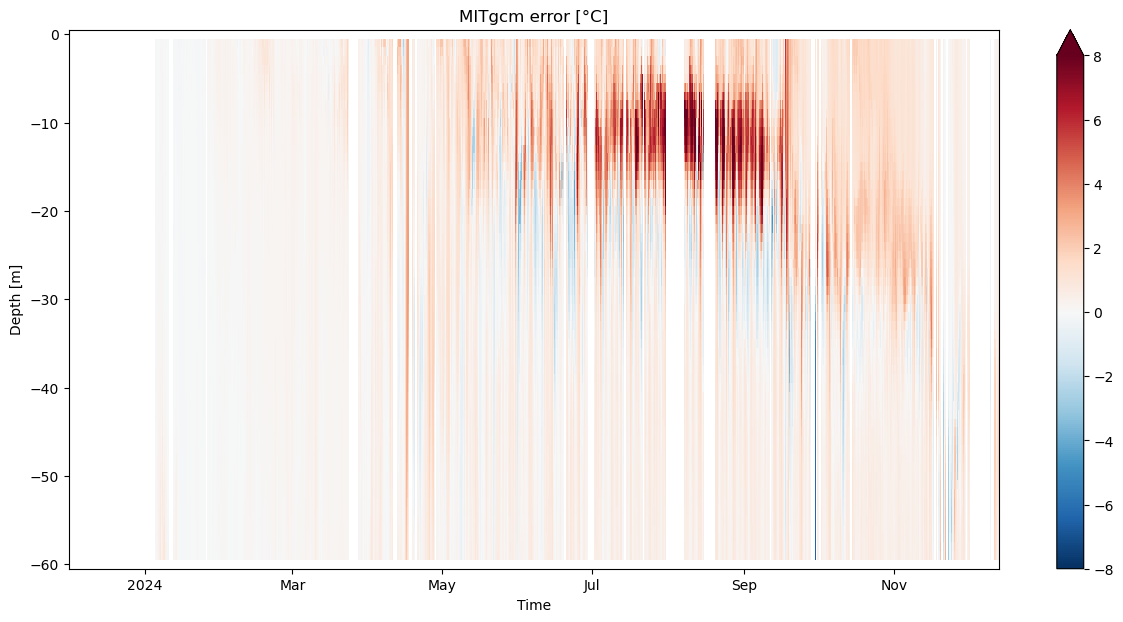

In [15]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(15, 7))

(mitgcm_interp.rename({'Z':'depth'}) - meas_interp).plot(x='time', vmax=8)
plt.title('MITgcm error [°C]')
plt.ylabel('Depth [m]')
plt.show()

## Plot heatmap

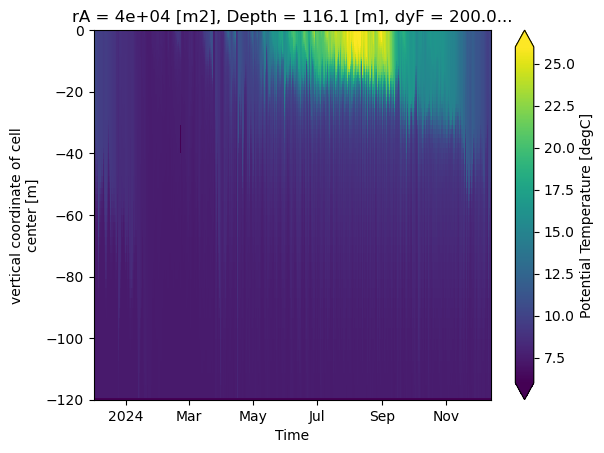

In [16]:
xr_mitgcm['THETA'].plot(x='time', vmin = 6, vmax=26)
plt.ylim(bottom=-120)
plt.show()

In [17]:
xr_measure['temp'].sel(time=slice(np.datetime64("2024-03-01"), np.datetime64("2024-12-01"))).plot(x='time', vmin = 6, vmax=26)
plt.ylim(bottom=-60)

(-60.0, 0.05)

# Heat content

In [18]:
import pylake

C:\Users\leroquan\AppData\Local\anaconda3\envs\mitgcm_env\lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [19]:
temp_meas = meas_interp.values
depth = meas_interp.depth.values
bthA = np.ones(61)
bthD = depth

In [20]:
heat_content_meas = pylake.heat_content(temp_meas, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [21]:
heat_content_mitgcm = pylake.heat_content(mitgcm_interp.values, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [22]:
heat_content_dalton = pylake.heat_content(mitgcm_dalton_interp.values, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [23]:
heat_content_secchi = pylake.heat_content(mitgcm_secchi_interp.values, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [24]:
heat_content_simstrat = pylake.heat_content(simstrat_interp.values, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [25]:
heat_content_meas = heat_content_meas.assign_coords(time=mitgcm_interp['time'])
heat_content_mitgcm = heat_content_mitgcm.assign_coords(time=mitgcm_interp['time'])
heat_content_dalton= heat_content_dalton.assign_coords(time=mitgcm_interp['time'])
heat_content_secchi= heat_content_secchi.assign_coords(time=mitgcm_interp['time'])
heat_content_simstrat = heat_content_simstrat.assign_coords(time=mitgcm_interp['time'])

In [26]:
heat_content_meas = heat_content_meas.where(heat_content_meas > 0, np.nan)
heat_content_mitgcm = heat_content_mitgcm.where(heat_content_mitgcm > 0, np.nan)
heat_content_dalton = heat_content_dalton.where(heat_content_dalton > 0, np.nan)
heat_content_secchi = heat_content_secchi.where(heat_content_secchi > 0, np.nan)
heat_content_simstrat = heat_content_simstrat.where(heat_content_simstrat > 0, np.nan)

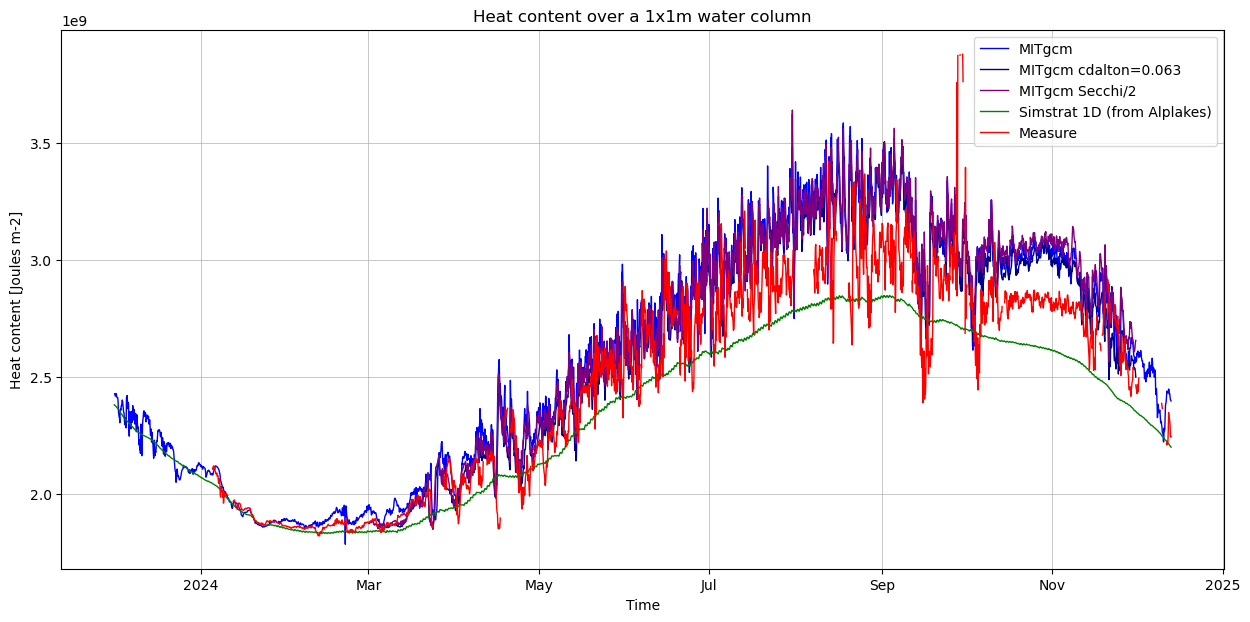

In [27]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(15, 7))

heat_content_mitgcm.plot(label='MITgcm', color='b', lw=1)
heat_content_dalton.plot(label='MITgcm cdalton=0.063', color='darkblue', lw=1)
heat_content_secchi.plot(label='MITgcm Secchi/2', color='purple', lw=1)
heat_content_simstrat.plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)
heat_content_meas.plot(label='Measure', color='red', lw=1)

plt.title('Heat content over a 1x1m water column')
plt.ylabel('Heat content [Joules m-2]')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

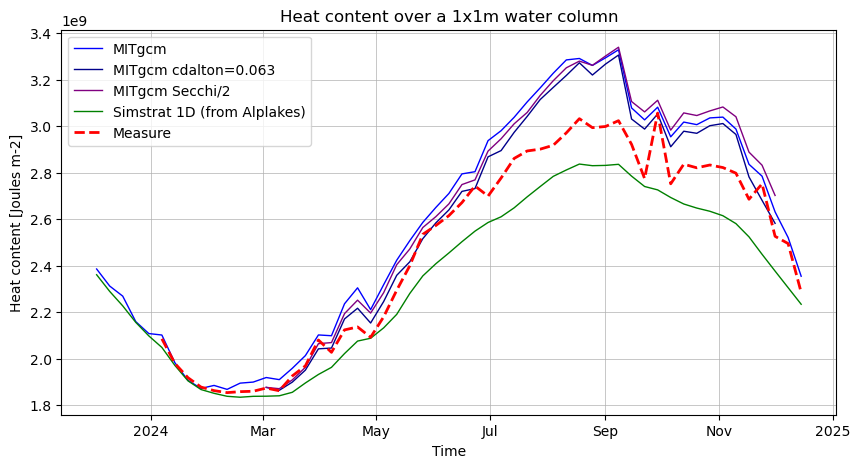

In [28]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(10, 5))

heat_content_mitgcm.resample(time='W').mean().plot(label='MITgcm', color='b', lw=1)
heat_content_dalton.resample(time='W').mean().plot(label='MITgcm cdalton=0.063', color='darkblue', lw=1)
heat_content_secchi.resample(time='W').mean().plot(label='MITgcm Secchi/2', color='purple', lw=1)
heat_content_simstrat.resample(time='W').mean().plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)
heat_content_meas.resample(time='W').mean().plot(label='Measure', color='red', lw=2, linestyle='--')

plt.title('Heat content over a 1x1m water column')
plt.ylabel('Heat content [Joules m-2]')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

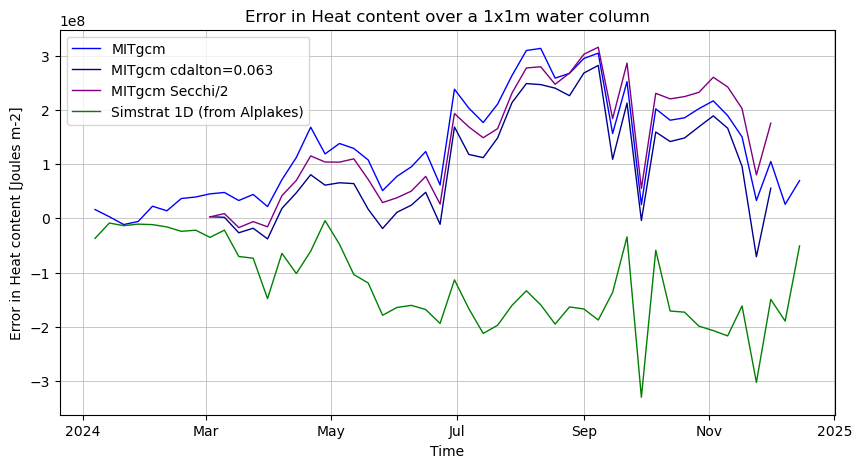

In [34]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(10, 5))

# Resample to monthly averages
(heat_content_mitgcm.resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label='MITgcm', color='b', lw=1)
(heat_content_dalton.resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label='MITgcm cdalton=0.063', color='darkblue', lw=1)
(heat_content_secchi.resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label='MITgcm Secchi/2', color='purple', lw=1)
(heat_content_simstrat.resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.title('Error in Heat content over a 1x1m water column')
plt.ylabel('Error in Heat content [Joules m-2]')
plt.show()

## Fluxes analysis

In [38]:
xr_flux = xr.open_dataset(r"D:\geneva_heat_fluxes\crop_results\lexplore_depth_time.nc")

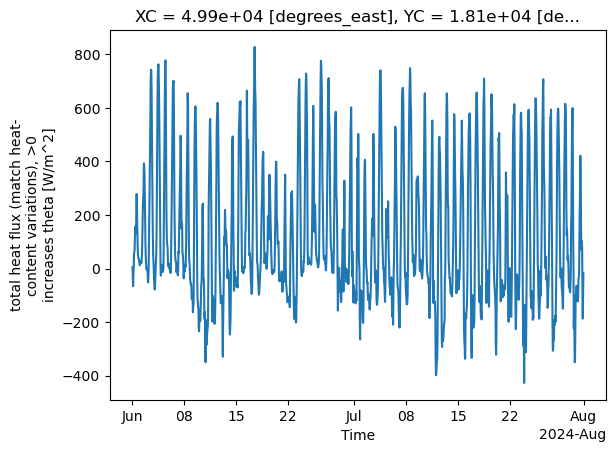

In [68]:
plt.close('all')
heat_flux_mitgcm_base =  xr_flux.TFLUX
heat_flux_mitgcm_base.plot()
plt.show()

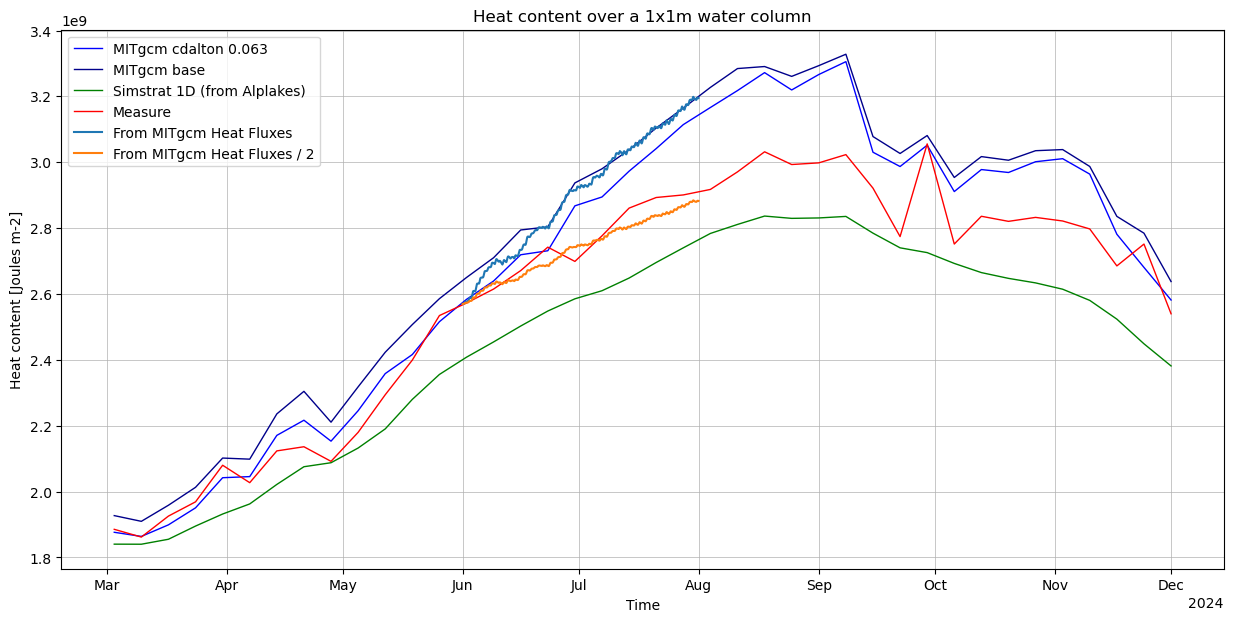

In [83]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(15, 7))

heat_content_mitgcm.resample(time='W').mean().plot(label='MITgcm cdalton 0.063', color='b', lw=1)
heat_content_mitgcm_base.resample(time='W').mean().plot(label='MITgcm base', color='darkblue', lw=1)
heat_content_simstrat.resample(time='W').mean().plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)
heat_content_meas.resample(time='W').mean().plot(label='Measure', color='red', lw=1)
(2.57e9 + heat_flux_mitgcm_base.cumsum(dim='time') * 3600).plot(label='From MITgcm Heat Fluxes')
(2.57e9 + heat_flux_mitgcm_base.cumsum(dim='time') * 3600 / 2).plot(label='From MITgcm Heat Fluxes / 2')

plt.title('Heat content over a 1x1m water column')
plt.ylabel('Heat content [Joules m-2]')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()